# 1. Initialisation du Notebook

Importation des bibliothèques utiles et définition des chemins d'accès aux données:

**- PATH_DATA**: Données d'entrainement

**- PATH_PREDICT_WITHOUT_GT**: Données de test


In [5]:
import h5py as h5
import numpy as np

PATH_DATA = '../half.h5'
PATH_PREDICT_WITHOUT_GT = '../pred_eighties_from_half_1_without_gt.h5'

In [6]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

In [7]:
idxs = get_idxs(PATH_DATA)
pred_idxs = get_idxs(PATH_PREDICT_WITHOUT_GT)

# 2. Affichage

Ici, on définit des fonctions qui permettront d'afficher les patchs _16x16_.
Tout d'abord, on s'amuse à créer un système d'affichage sympa pour voir ce que fait l'algorithme pendant qu'il tourne.

In [16]:
def funky_print(arg, arg_max):
    """ Un affichage joli """
    line = ""
    dgt_arg = len(str(arg))
    dgt_arg_max = len(str(arg_max))
    while dgt_arg_max > dgt_arg:
        line += " "
        dgt_arg += 1
    line += str(arg)
    return line

Afin d'afficher clairement les images, on cherche à les traiter. Pour ce faire, on va tout d'abord chercher la balance des blancs. On suppose que sur la totalité des images, il y a au moins 1 pixel représentant du blanc. Ce pixel va servir de base à l'étalonnage de toutes les images.

Voici ici l'algorithme permettant de trouver cette balance:

In [19]:
[abs_max_r, abs_max_g, abs_max_b, abs_max_ir] = [0, 0, 0, 0]

f = h5.File(PATH_DATA)
count = 0
n = len(idxs)

print('>>> %s / %d | (R:%s, G:%s, B:%s, IR:%s)' % (funky_print(0, n), n, funky_print(int(abs_max_r), 2**16), funky_print(int(abs_max_g), 2**16), funky_print(int(abs_max_b), 2**16), funky_print(int(abs_max_ir), 2**16)))
for idx in idxs:
    count += 1
    rgb16 = f['S2'][idx,:,:,:]
    [max_r, max_g, max_b, max_ir] = [0,0,0,0]
    for i in range(16):
        for j in range(16):
            [r,g,b,ir] = rgb16[i,j,:]
            if r*g*b > max_r*max_g*max_b:
                max_r, max_g, max_b = r, g, b
            if ir > max_ir:
                max_ir = ir
    if max_r*max_g*max_b > abs_max_r*abs_max_g*abs_max_b:
        abs_max_r, abs_max_g, abs_max_b = max_r, max_g, max_b
    if max_ir > abs_max_ir:
        abs_max_ir = max_ir
    if (count%10000 == 0):
        print('>>> %s / %d | (R:%s, G:%s, B:%s, IR:%s)' % (funky_print(count, n), n, funky_print(int(abs_max_r), 2**16), funky_print(int(abs_max_g), 2**16), funky_print(int(abs_max_b), 2**16), funky_print(int(abs_max_ir), 2**16)))

>>>       0 / 9349120 | (R:    0, G:    0, B:    0, IR:    0)
>>>   10000 / 9349120 | (R:  469, G:  679, B:  939, IR:  437)
>>>   20000 / 9349120 | (R:  532, G:  690, B:  952, IR:  437)
>>>   30000 / 9349120 | (R:  453, G:  765, B: 1058, IR:  453)
>>>   40000 / 9349120 | (R:  526, G:  836, B: 1117, IR:  530)
>>>   50000 / 9349120 | (R:  634, G:  805, B: 1004, IR:  530)
>>>   60000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>   70000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>   80000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>   90000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  100000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  110000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  120000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  130000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  140000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 1951)
>>>  150000 / 9349120 | (R: 2222, G: 2580, B: 2942, IR: 2660)
>>>  160

KeyboardInterrupt: 

In [22]:
print('MAX WHITE = (R:%s, G:%s, B:%s)' % (funky_print(int(abs_max_r), 2**16), funky_print(int(abs_max_g), 2**16), funky_print(int(abs_max_b), 2**16)))
print('MAX IR =    (IR:%s)' % funky_print(int(abs_max_ir), 2**16))

MAX WHITE = (R: 7817, G: 7143, B: 7086)
MAX IR =    (IR: 8467)


Maintenant que la balance des blancs est trouvée. On peut afficher les images. Malgré l'algorithme précédent, les images restent très sombre. On privilégie donc la visibilité des données au détriment de quelques pixels saturés en augmentant la saturation des données...

In [67]:
from matplotlib import pyplot as plt

def process_16bit_to_8bit(rgb16):
    """ Traduit l'image 16bit en image 8bit """
    MAX_R  = 4000
    MAX_G  = 4000
    MAX_B  = 4000
    MAX_IR = 10361
    MAX_COLORS = [MAX_R, MAX_G, MAX_B, MAX_IR]
    ratio  = 1.1
    height = len(rgb16)
    width  = len(rgb16[0])
    for i in range(height):
        for j in range(width):
            for col in range(len(rgb16[i,j])):
                rgb16[i,j,col] = rgb16[i,j,col]/(MAX_COLORS[col]*ratio)
    return (rgb16*256).astype('uint8')

def display_img(h5_path, idx, show_lbl=False, show_ir=False):
    """ Affiche l'image située à l'index idx """
    f = h5.File(h5_path, 'r')
    rgb8 = process_16bit_to_8bit(f['S2'][idx,:,:,:])
    height = len(rgb8)
    width  = len(rgb8[0])
    if show_ir:
        img = np.zeros((height, width*2, 3))
        img[:,:width,:] = rgb8[:,:,:3]
        for i in range(height):
            for j in range(width):
                img[i,j + width,:] = [rgb8[i,j,3],rgb8[i,j,3],rgb8[i,j,3]]
    else:
        img = np.zeros((height, width, 3))
        img[:,:width,:] = rgb8[:,:,:3]
    plt.imshow(img)
    if show_lbl:
        plt.text(-0.4,0.4, 'IMG_%d' % idx)
        plt.text(-0.4,height-0.6, 'Label:%d' % f['TOP_LANDCOVER'][idx])
    plt.show()

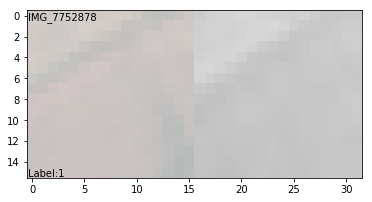

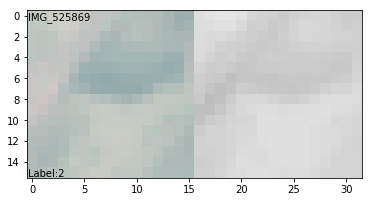

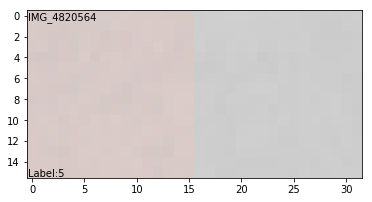

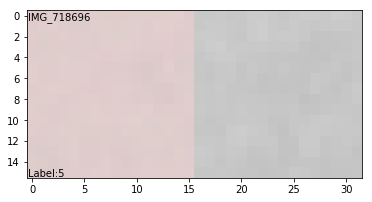

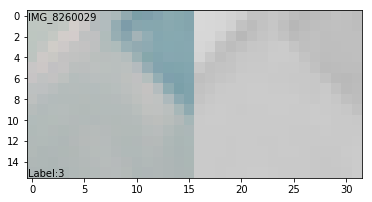

In [68]:
import random

NB_TESTS = 5
random_idxs = [random.choice(idxs) for x in range(NB_TESTS)]

for idx in random_idxs:
    display_img(PATH_DATA, idx, show_lbl=True, show_ir=True)

Désormais, maintenant que l'on sait afficher une image, on va chercher à afficher plusieurs patchs les uns à la suite des autres afin de connaître la corrélation entre les différents patchs:

In [265]:
import sys

def display_multiple_img(h5_path, m_idxs, show_lbl=False, show_ir=False, size=4):
    """ Affiche une liste d'images """
    if show_ir:
        toolbar_width = 16
        progress = 0
        sys.stdout.write("Affichage en cours... [%s] %s %%" % (" " * toolbar_width, funky_print(0,100)))
        f = h5.File(h5_path, 'r')
        height = 16
        width  = 16
        final_height = 16*len(m_idxs)
        final_width  = 16*len(m_idxs[0])
        final_img = np.zeros((final_height, final_width, 3))
        count = 0
        for id_i in range(len(m_idxs)):
            progress += 1
            for id_j in range(len(m_idxs[0])):
                count += 1
                sys.stdout.write("\rAffichage en cours... [%s] %s %%" % ("#" * (progress*toolbar_width//len(m_idxs)) + " " * (toolbar_width-(progress*toolbar_width//len(m_idxs))), funky_print(int((count)/(m_idxs.shape[0]*m_idxs.shape[1])*100),100)))
                rgb8 = process_16bit_to_8bit(f['S2'][m_idxs[id_i,id_j],:,:,:])
                for i in range(len(rgb8)):
                    for j in range(len(rgb8[i])):
                        final_img[id_i*height+i,id_j*width+j,:] = [rgb8[i,j,3],rgb8[i,j,3],rgb8[i,j,3]]
        plt.figure(figsize=(size, size))
        plt.imshow(final_img)
        if show_lbl:
            plt.text(final_width/(10*size),final_height/(5*size), 'IMG_%d' % m_idxs[0,0])
            plt.text(final_width/(10*size),final_height-final_height/(10*size), 'Size:%d/%d' % m_idxs.shape)
        plt.show()
    else:
        toolbar_width = 16
        progress = 0
        sys.stdout.write("Affichage en cours... [%s] %s %%" % (" " * toolbar_width, funky_print(0,100)))
        f = h5.File(h5_path, 'r')
        height = 16
        width  = 16
        final_height = 16*len(m_idxs)
        final_width  = 16*len(m_idxs[0])
        final_img = np.zeros((final_height, final_width, 3))
        count = 0
        for id_i in range(len(m_idxs)):
            progress += 1
            for id_j in range(len(m_idxs[0])):
                count += 1
                sys.stdout.write("\rAffichage en cours... [%s] %s %%" % ("#" * (progress*toolbar_width//len(m_idxs)) + " " * (toolbar_width-(progress*toolbar_width//len(m_idxs))), funky_print(int((count)/(m_idxs.shape[0]*m_idxs.shape[1])*100),100)))
                rgb8 = process_16bit_to_8bit(f['S2'][m_idxs[id_i,id_j],:,:,:])
                final_img[id_i*height:(id_i+1)*height,id_j*width:(id_j+1)*width,:] = rgb8[:,:,:3]
        plt.figure(figsize=(size, size))
        plt.imshow(final_img)
        if show_lbl:
            plt.text(final_width/(10*size),final_height/(5*size), 'IMG_%d' % m_idxs[0,0])
            plt.text(final_width/(10*size),final_height-final_height/(10*size), 'Size:%d/%d' % m_idxs.shape)
        plt.show()

Affichage en cours... [################] 100 %

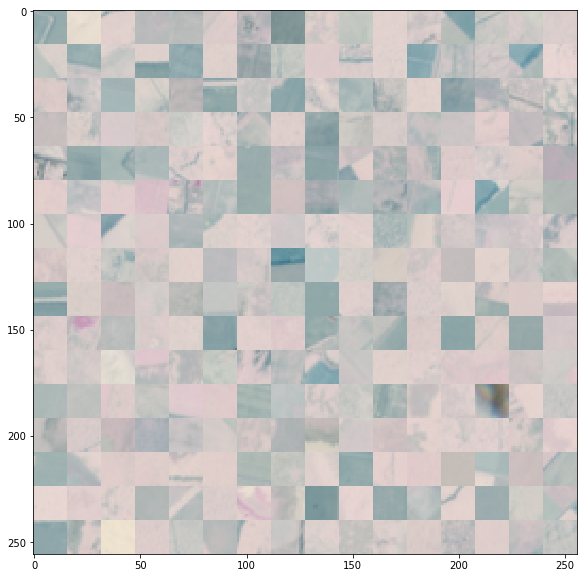

In [249]:
random_idxs = np.zeros((16,16))

for i in range(16):
    for j in range(16):
        random_idxs[i,j] = random.choice(idxs)

display_multiple_img(PATH_DATA, random_idxs, show_lbl=False, show_ir=False, size=10)

On cherche maintenant à afficher la totalité d'une image (_1024x1024_). On choisit donc un index aléatoire que l'on va modifier jusqu'à avoir l'image complète.

In [198]:
idx = random.choice(idxs)
print("RANDOM IDX : %d" % idx)

RANDOM IDX : 7609965


Affichage en cours... [################] 100 %

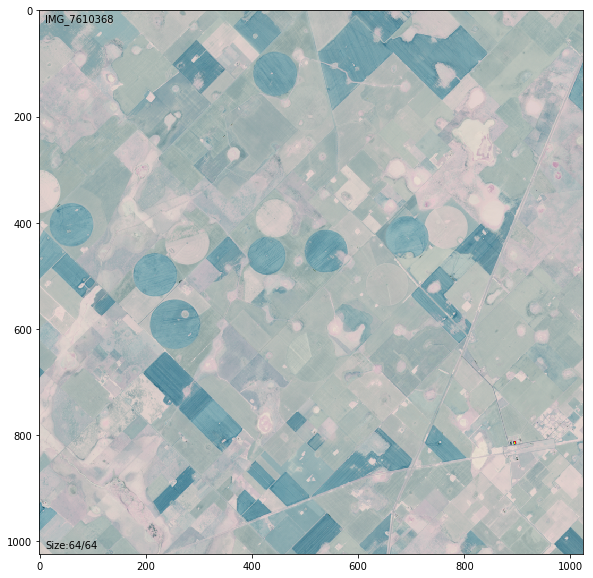

Affichage en cours... [################] 100 %

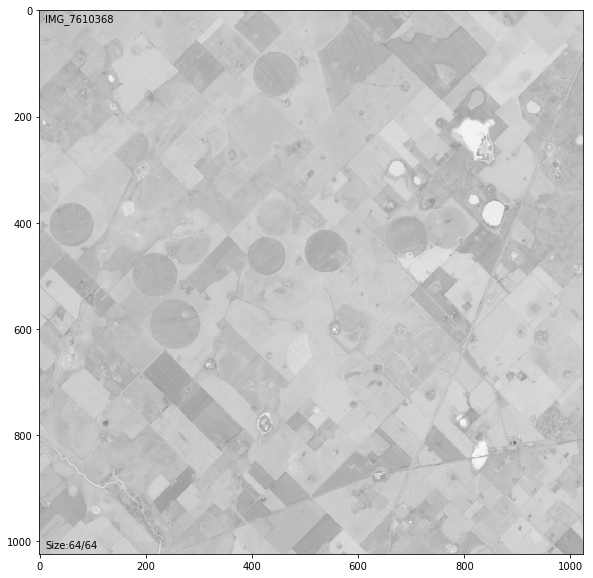

In [267]:
idx = 7609965
offset = 403
sample_idxs = np.zeros((64,64))

count = -1
for i in range(sample_idxs.shape[0]):
    for j in range(sample_idxs.shape[1]):
        count += 1
        sample_idxs[i,j] = idx + offset + count

display_multiple_img(PATH_DATA, sample_idxs, show_lbl=True, show_ir=False, size=10)
display_multiple_img(PATH_DATA, sample_idxs, show_lbl=True, show_ir=True, size=10)

# 3. Analyse des données à labelliser
Maintenant que tout ceci est fait on va s'intéresser aux données à labelliser. Pour ce faire, on charge les données et, comme précédemment, on affiche une image (_1024x1024_).

In [268]:
idx = random.choice(pred_idxs)
print("RANDOM IDX FROM PRED: %d" % idx)

RANDOM IDX FROM PRED: 123060


Affichage en cours... [################] 100 %

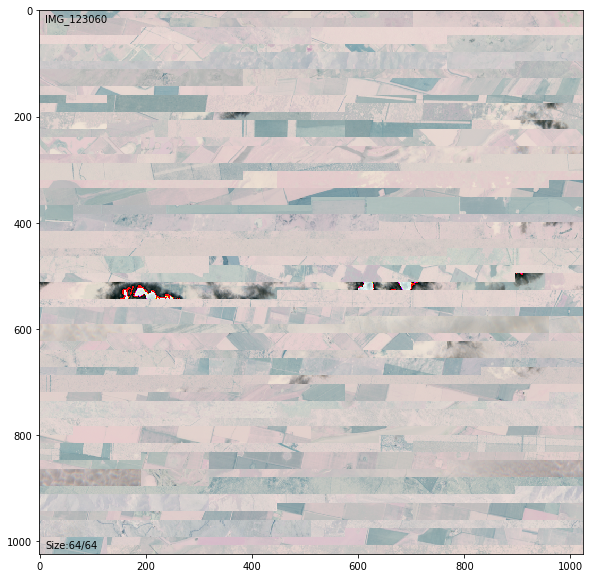

In [271]:
idx = 123060
offset = 0
sample_idxs = np.zeros((64,64))

count = -1
for i in range(sample_idxs.shape[0]):
    for j in range(sample_idxs.shape[1]):
        count += 1
        sample_idxs[i,j] = idx + offset + count

display_multiple_img(PATH_PREDICT_WITHOUT_GT, sample_idxs, show_lbl=True, show_ir=False, size=10)

Une première analyse montre qu'un tirage aléatoire est effectuée sur les patchs. Malgré tout, on discerne des régions: les patchs ne sont pas décorrélés les uns des autres, on observe des séquences d'images qui se suivent.

Un traitement sur une image (_1024x1024_), même si il avait été possible de le faire, est inutile. Néanmoins, on peut observer une corrélation des images en ligne et il serait intéressant de rendre compte de ce phénomène.

# 4. Etude de la corrélation

On se propose donc d'étudier la corrélation entre les patchs qui se suivent. Tout d'abord, l'étude se concentrera sur la corrélation des patchs de _half.h5_. Ainsi, on crée un liste qui va agir comme une version compressée des labels du jeu de données. La liste sera constituée d'un succession de 2 entiers:
- **premier entier**: représente la classe du patch
- **second entier**: nombre de patchs successifs ayant le même label

### ATTENTION ! NE PAS LANCER LE CODE CI-DESSOUS SAUF SI VOUS AVEZ DU TEMPS DEVANT VOUS

In [284]:
f = h5.File(PATH_DATA, 'r')

count = 1
n = len(idxs)

lbl_list = []
tmp_lbl = -1
tmp_count = 1
print('>>> %s / %d | length: %s | current:[lbl, %snb ]' % (" " * len(str(n)), n, " " * len(str(n)), " " * (len(str(1000000))-2)))
for idx in idxs:
    lbl = f['TOP_LANDCOVER'][idx][0].astype('uint8')
    if lbl != tmp_lbl:
        tmp_lbl = lbl
        tmp_count = 0
        lbl_list.append([tmp_lbl, tmp_count])
    tmp_count += 1
    lbl_list[-1][1] = tmp_count
    if (count%10000 == 0):
        print('>>> %s / %d | length: %s | current:[ %s, %s ]' % (funky_print(count, n), n, funky_print(len(lbl_list),n), funky_print(tmp_lbl,23), funky_print(tmp_count,1000000)))
    count+=1

>>>         / 9349120 | length:         | current:[lbl,      nb ]
>>>   10000 / 9349120 | length:       1 | current:[ 20,   10000 ]
>>>   20000 / 9349120 | length:       1 | current:[ 20,   20000 ]
>>>   30000 / 9349120 | length:       1 | current:[ 20,   30000 ]
>>>   40000 / 9349120 | length:       1 | current:[ 20,   40000 ]
>>>   50000 / 9349120 | length:       1 | current:[ 20,   50000 ]
>>>   60000 / 9349120 | length:       1 | current:[ 20,   60000 ]
>>>   70000 / 9349120 | length:       1 | current:[ 20,   70000 ]
>>>   80000 / 9349120 | length:       1 | current:[ 20,   80000 ]
>>>   90000 / 9349120 | length:       1 | current:[ 20,   90000 ]
>>>  100000 / 9349120 | length:       1 | current:[ 20,  100000 ]
>>>  110000 / 9349120 | length:       1 | current:[ 20,  110000 ]
>>>  120000 / 9349120 | length:       1 | current:[ 20,  120000 ]
>>>  130000 / 9349120 | length:       1 | current:[ 20,  130000 ]
>>>  140000 / 9349120 | length:       1 | current:[ 20,  140000 ]
>>>  15000

>>> 1250000 / 9349120 | length:  140335 | current:[  5,       2 ]
>>> 1260000 / 9349120 | length:  141518 | current:[  5,      14 ]
>>> 1270000 / 9349120 | length:  142146 | current:[  4,       8 ]
>>> 1280000 / 9349120 | length:  143472 | current:[ 12,       2 ]
>>> 1290000 / 9349120 | length:  144150 | current:[  4,      11 ]
>>> 1300000 / 9349120 | length:  145460 | current:[  3,      10 ]
>>> 1310000 / 9349120 | length:  146656 | current:[  5,      33 ]
>>> 1320000 / 9349120 | length:  147861 | current:[  3,       2 ]
>>> 1330000 / 9349120 | length:  149430 | current:[  5,       4 ]
>>> 1340000 / 9349120 | length:  150807 | current:[  5,       6 ]
>>> 1350000 / 9349120 | length:  152647 | current:[  2,       1 ]
>>> 1360000 / 9349120 | length:  154622 | current:[  5,       3 ]
>>> 1370000 / 9349120 | length:  156207 | current:[  4,      19 ]
>>> 1380000 / 9349120 | length:  158225 | current:[  2,       6 ]
>>> 1390000 / 9349120 | length:  159905 | current:[  5,       2 ]
>>> 140000

>>> 2500000 / 9349120 | length:  354065 | current:[ 12,     196 ]
>>> 2510000 / 9349120 | length:  354437 | current:[ 12,     153 ]
>>> 2520000 / 9349120 | length:  355709 | current:[  5,       3 ]
>>> 2530000 / 9349120 | length:  357349 | current:[ 12,       3 ]
>>> 2540000 / 9349120 | length:  358484 | current:[  1,       6 ]
>>> 2550000 / 9349120 | length:  360137 | current:[  1,       2 ]
>>> 2560000 / 9349120 | length:  361607 | current:[  3,       7 ]
>>> 2570000 / 9349120 | length:  363586 | current:[ 12,       5 ]
>>> 2580000 / 9349120 | length:  365560 | current:[ 17,       6 ]
>>> 2590000 / 9349120 | length:  367217 | current:[  1,       2 ]
>>> 2600000 / 9349120 | length:  368879 | current:[  1,       3 ]
>>> 2610000 / 9349120 | length:  370686 | current:[  2,       3 ]
>>> 2620000 / 9349120 | length:  372945 | current:[ 12,       2 ]
>>> 2630000 / 9349120 | length:  374839 | current:[  1,       5 ]
>>> 2640000 / 9349120 | length:  376768 | current:[  3,      38 ]
>>> 265000

>>> 3750000 / 9349120 | length:  473071 | current:[  5,      46 ]
>>> 3760000 / 9349120 | length:  473922 | current:[  3,       2 ]
>>> 3770000 / 9349120 | length:  475315 | current:[  3,       6 ]
>>> 3780000 / 9349120 | length:  477421 | current:[  3,       8 ]
>>> 3790000 / 9349120 | length:  479087 | current:[ 12,       1 ]
>>> 3800000 / 9349120 | length:  480459 | current:[ 12,       2 ]
>>> 3810000 / 9349120 | length:  481964 | current:[ 12,       4 ]
>>> 3820000 / 9349120 | length:  483052 | current:[ 12,       2 ]
>>> 3830000 / 9349120 | length:  483527 | current:[ 12,      14 ]
>>> 3840000 / 9349120 | length:  484206 | current:[ 12,       8 ]
>>> 3850000 / 9349120 | length:  484580 | current:[ 12,     570 ]
>>> 3860000 / 9349120 | length:  485422 | current:[ 12,       7 ]
>>> 3870000 / 9349120 | length:  486295 | current:[  3,       3 ]
>>> 3880000 / 9349120 | length:  487343 | current:[ 12,      20 ]
>>> 3890000 / 9349120 | length:  488426 | current:[ 12,       1 ]
>>> 390000

>>> 5000000 / 9349120 | length:  580138 | current:[ 12,       5 ]
>>> 5010000 / 9349120 | length:  581539 | current:[ 12,       4 ]
>>> 5020000 / 9349120 | length:  583627 | current:[  3,       3 ]
>>> 5030000 / 9349120 | length:  585546 | current:[ 20,      11 ]
>>> 5040000 / 9349120 | length:  586842 | current:[  3,       3 ]
>>> 5050000 / 9349120 | length:  588340 | current:[  5,       6 ]
>>> 5060000 / 9349120 | length:  590031 | current:[ 12,       1 ]
>>> 5070000 / 9349120 | length:  590616 | current:[ 12,       8 ]
>>> 5080000 / 9349120 | length:  591657 | current:[  5,       5 ]
>>> 5090000 / 9349120 | length:  593038 | current:[  5,       9 ]
>>> 5100000 / 9349120 | length:  594765 | current:[ 12,      27 ]
>>> 5110000 / 9349120 | length:  595871 | current:[  3,       3 ]
>>> 5120000 / 9349120 | length:  597578 | current:[ 12,       5 ]
>>> 5130000 / 9349120 | length:  598456 | current:[ 12,       1 ]
>>> 5140000 / 9349120 | length:  600148 | current:[  3,       3 ]
>>> 515000

>>> 6250000 / 9349120 | length:  767164 | current:[  1,      14 ]
>>> 6260000 / 9349120 | length:  769039 | current:[  3,       2 ]
>>> 6270000 / 9349120 | length:  770219 | current:[  1,      24 ]
>>> 6280000 / 9349120 | length:  770715 | current:[  1,       7 ]
>>> 6290000 / 9349120 | length:  771739 | current:[  1,       6 ]
>>> 6300000 / 9349120 | length:  773012 | current:[  1,      30 ]
>>> 6310000 / 9349120 | length:  774053 | current:[  1,       5 ]
>>> 6320000 / 9349120 | length:  774571 | current:[  1,      25 ]
>>> 6330000 / 9349120 | length:  775744 | current:[  1,       8 ]
>>> 6340000 / 9349120 | length:  776620 | current:[  1,       6 ]
>>> 6350000 / 9349120 | length:  777397 | current:[  1,     117 ]
>>> 6360000 / 9349120 | length:  778157 | current:[  3,       2 ]
>>> 6370000 / 9349120 | length:  779353 | current:[  1,      36 ]
>>> 6380000 / 9349120 | length:  780484 | current:[  1,       6 ]
>>> 6390000 / 9349120 | length:  781295 | current:[  1,     259 ]
>>> 640000

>>> 7500000 / 9349120 | length:  900067 | current:[  1,       1 ]
>>> 7510000 / 9349120 | length:  901479 | current:[  1,     221 ]
>>> 7520000 / 9349120 | length:  902379 | current:[  1,      16 ]
>>> 7530000 / 9349120 | length:  903854 | current:[  3,       1 ]
>>> 7540000 / 9349120 | length:  905152 | current:[  1,      32 ]
>>> 7550000 / 9349120 | length:  906134 | current:[  1,     331 ]
>>> 7560000 / 9349120 | length:  907429 | current:[  1,       5 ]
>>> 7570000 / 9349120 | length:  908394 | current:[  1,       4 ]
>>> 7580000 / 9349120 | length:  910204 | current:[  3,       2 ]
>>> 7590000 / 9349120 | length:  911728 | current:[  1,       7 ]
>>> 7600000 / 9349120 | length:  913011 | current:[  1,      22 ]
>>> 7610000 / 9349120 | length:  914667 | current:[  1,       4 ]
>>> 7620000 / 9349120 | length:  916562 | current:[  1,       2 ]
>>> 7630000 / 9349120 | length:  918258 | current:[  3,       3 ]
>>> 7640000 / 9349120 | length:  919227 | current:[  1,     373 ]
>>> 765000

>>> 8750000 / 9349120 | length: 1083554 | current:[  1,      10 ]
>>> 8760000 / 9349120 | length: 1084428 | current:[  1,    1196 ]
>>> 8770000 / 9349120 | length: 1085299 | current:[  1,      16 ]
>>> 8780000 / 9349120 | length: 1086513 | current:[  2,       1 ]
>>> 8790000 / 9349120 | length: 1087729 | current:[  3,      10 ]
>>> 8800000 / 9349120 | length: 1088576 | current:[  1,    1840 ]
>>> 8810000 / 9349120 | length: 1089220 | current:[  1,      15 ]
>>> 8820000 / 9349120 | length: 1090441 | current:[  2,       6 ]
>>> 8830000 / 9349120 | length: 1091690 | current:[  3,       5 ]
>>> 8840000 / 9349120 | length: 1093226 | current:[  1,     507 ]
>>> 8850000 / 9349120 | length: 1094314 | current:[  1,       5 ]
>>> 8860000 / 9349120 | length: 1095558 | current:[  1,       4 ]
>>> 8870000 / 9349120 | length: 1096423 | current:[  1,      24 ]
>>> 8880000 / 9349120 | length: 1098026 | current:[  2,       2 ]
>>> 8890000 / 9349120 | length: 1099043 | current:[  2,       1 ]
>>> 890000

On enregistre la liste dans un fichier afin de le réutiliser plus tard. 

In [287]:
#np.savetxt('lbl_list_1.csv', np.asarray(lbl_list), delimiter=',')

Maintenant que nous avons créé cette liste, il ne reste plus qu'à compter les transitions et ainsi construire une matrice de transition entre patchs. On commence par charger la liste des labels qu'on vient d'enregistrer.

In [288]:
lbl_array = np.genfromtxt('lbl_list_1.csv', delimiter=',')

In [301]:
transition_matrix = np.zeros((23,23))

progress = 0
toolbar_width = 16

for i in range(len(lbl_array)):
    [lbl, count] = lbl_array[i][:]
    [p_lbl, p_count] = lbl_array[i-1][:]
    lbl = int(lbl)
    p_lbl = int(p_lbl)
    transition_matrix[lbl,lbl] += count
    transition_matrix[lbl,p_lbl] += 1
    transition_matrix[p_lbl,lbl] += 1

In [302]:
#np.savetxt('transition_matrix_1.csv', transition_matrix, delimiter=',')

In [303]:
print(transition_matrix)

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 2.583182e+06 1.203420e+05 2.256880e+05 2.420000e+03
  5.482000e+03 1.600000e+01 0.000000e+00 0.000000e+00 0.000000e+00
  4.449000e+03 1.480000e+02 1.014000e+04 0.000000e+00 1.800000e+02
  0.000000e+00 0.000000e+00 3.990000e+02 7.800000e+01 1.160000e+03
  1.388000e+03 0.000000e+00 0.000000e+00]
 [0.000000e+00 1.203420e+05 7.470830e+05 1.905500e+05 1.021700e+04
  2.528200e+04 1.400000e+01 0.000000e+00 0.000000e+00 0.000000e+00
  6.600000e+02 2.360000e+02 6.464000e+04 0.000000e+00 1.800000e+02
  1.000000e+01 0.000000e+00 9.980000e+02 5.900000e+01 3.000000e+02
  2.078000e+03 0.000000e+00 0.000000e+00]
 [0.000000e+00 2.256880e+05 1.905500e+05 1.549478e+06 6.149000e+03
  3